# `l2hmc-qcd`

This notebook contains a minimal working example for the 4D SU(3) Model

Uses `torch.complex128` by default

## Setup

In [1]:
! nvidia-smi | tail --lines -7

+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+


In [2]:
import lovely_tensors as lt

# automatically detect and reload local changes to modules
%load_ext autoreload
%autoreload 2
lt.monkey_patch()
lt.set_config(color=False)

In [3]:
import os
# --------------------------------------
# BE SURE TO GRAB A FRESH GPU !
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
#!echo $CUDA_VISIBLE_DEVICES
# --------------------------------------
os.environ['COLORTERM'] = 'truecolor'

In [4]:
#devices = os.environ.get('CUDA_VISIBLE_DEVICES', None)
#print(devices)
# get number of available CPUs
!getconf _NPROCESSORS_ONLN

256


In [5]:
from __future__ import absolute_import, print_function, annotations, division

import warnings

import torch
import numpy as np

from hydra.core.global_hydra import GlobalHydra

warnings.filterwarnings('ignore')

os.environ['MASTER_PORT'] = '4526'
#os.environ['OMP_NUM_THREADS'] = '256'

np.set_printoptions(threshold=5)
torch.set_printoptions(threshold=5, precision=5)

In [6]:
from l2hmc.utils.dist import (
    setup_torch
)
_ = setup_torch(
    precision='float64',
    backend='deepspeed',
    seed=1234,
)

--------------------------------------------------------------------------

  Local host:   thetagpu23
  Local device: mlx5_0
--------------------------------------------------------------------------
2023-07-03 13:00:31.402675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[2023-07-03 13:01:46,676] [INFO] [comm.py:606:init_distributed] Not using the DeepSpeed or dist launchers, attempting to detect MPI environment...
[2023-07-03 13:01:46,684] [INFO] [comm.py:656:mpi_discovery] Discovered MPI settings of world_rank=0, local_rank=0, world_size=1, master_addr=10.230.2.211, master_port=29500
[2023-07-03 13:01:46,684] [INFO] [comm.py:622:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl
[07/03/23 13:01:46][WARNING][dist.py:332] - Setting default dtype: float64
[07/03/23 13:01:46][INFO][dist.py:338] - Global Rank: 0 / 0


In [7]:
from l2hmc.experiment.pytorch.experiment import Experiment as ptExperiment

import l2hmc.group.su3.pytorch.group as gpt
ptsu3 = gpt.SU3()

import l2hmc
l2hmc.__file__

'/lus/grand/projects/datascience/foremans/locations/thetaGPU/projects/saforem2/l2hmc-qcd/src/l2hmc/__init__.py'

In [8]:
%matplotlib widget
import matplotlib.pyplot as plt

from l2hmc.common import grab_tensor, print_dict
from l2hmc.utils.plot_helpers import set_plot_style

set_plot_style()

from l2hmc.utils.plot_helpers import (  # noqa
    set_plot_style,
    plot_scalar,
    plot_chains,
    plot_leapfrogs
)


def plot_metrics(metrics: dict, title: Optional[str] = None, **kwargs):
    for key, val in metrics.items():
        fig, ax = plot_metric(val, name=key, **kwargs)
        if title is not None:
            ax.set_title(title)


def plot_metric(
        metric: torch.Tensor,
        name: Optional[str] = None,
        **kwargs,
):
    assert len(metric) > 0
    if isinstance(metric[0], (int, float, bool, np.floating)):
        y = np.stack(metric)
        return plot_scalar(y, ylabel=name, **kwargs)
    element_shape = metric[0].shape
    if len(element_shape) == 2:
        y = grab_tensor(torch.stack(metric))
        return plot_leapfrogs(y, ylabel=name)
    if len(element_shape) == 1:
        y = grab_tensor(torch.stack(metric))
        return plot_chains(y, ylabel=name, **kwargs)
    if len(element_shape) == 0:
        y = grab_tensor(torch.stack(metric))
        return plot_scalar(y, ylabel=name, **kwargs)
    raise ValueError

## Helper Functions

In [9]:
# backward hook with module name
def get_backward_hook(module_name: str):
    class BackwardHook:
        name: str
        def __init__(self, name):
            self.name = name
        def __call__(self, module, grad_input, grad_output):
            for i, g_in in enumerate(grad_input):
                print(module_name, torch.any(torch.isnan(g_in)))
                if torch.any(torch.isnan(g_in)):
                    print(f"{module_name}'s {i}th input gradient is nan")
            for i, g_out in enumerate(grad_output):
                if torch.any(torch.isnan(g_out)):
                    print(f"{module_name}'s {i}th output gradient is nan")
    return BackwardHook(module_name)

import torch
from torchview import draw_graph

from l2hmc.trainers.pytorch.trainer import Trainer  # noqa
def print_weights(trainer: Trainer, grab: bool = True):
    _ = print_dict({
        k: v for k, v in trainer.dynamics.named_parameters()
    })


def print_grads(trainer: Trainer, grab: bool = True):
    _ = print_dict({
        k: v.grad for k, v in trainer.dynamics.named_parameters()
    })


def print_grads_and_weights(trainer: Trainer, grab: bool = True):
    print(80 * '-')
    print('GRADS:')
    print_grads(trainer)
    print(80 * '-')
    print('WEIGHTS:')
    print_weights(trainer)
    print(80 * '-')


def calc_loss(
        x: torch.Tensor,
        y: torch.Tensor,
        acc: torch.Tensor
) -> torch.Tensor:
    dx = (x - y)
    dx2 = (dx.real.pow(2) + dx.imag.pow(2)).flatten(1)
    return (acc * dx2.mean(1)).sum()


def train_step(
        x: torch.Tensor,
        beta: float | torch.Tensor,
        trainer: Trainer,
) -> tuple[torch.Tensor, dict]:
    if isinstance(beta, float):
        beta = torch.tensor(beta)
    x.requires_grad_(True)
    trainer.optimizer.zero_grad()
    xout, metrics = trainer.dynamics_engine((x, beta))
    xprop = metrics.pop('mc_states').proposed.x
    loss = calc_loss(x, xprop, metrics['acc'])
    loss.backward()
    torch.nn.utils.clip_grad.clip_grad_norm(
        trainer.dynamics.parameters(),
        max_norm=float(1e-6),
    )
    trainer.optimizer.step()
    metrics |= {'loss': loss.item()}
    print_dict(metrics, grab=False)
    #loss = trainer.backward_step(loss)
    #dx = (x - xprop).abs().flatten(1).mean(-1)
    #loss = (metrics['acc'] * dx).mean()
    #loss = trainer.calc_loss(
    #    xinit=x,
    #    xprop=xprop,
    #    acc=metrics['acc']
    #)
    return xout.detach(), metrics

## Specify defaults for building Experiment

In [10]:
GlobalHydra.instance().clear()

In [11]:
DEFAULTS = {
    'save': False,
    'restore': False,
    'init_aim': False,
    'init_wandb': False,
    'use_wandb': False,
    'use_tb': False,
    'backend': 'deepspeed',
    'framework': 'pytorch',
    'conv': 'none',
    'network': {
        'use_batch_norm': False,
        'activation_fn': 'relu',
        'dropout_prob': 0.0,
        'units': [1],
    },
    'dynamics': {
        'group': 'SU3',
        'eps': 0.1,
        'nchains': 1,
        'nleapfrog': 1,
        'verbose': True,
        'latvolume': [1, 1, 1, 1],
        'eps_fixed': False,
        'merge_directions': True,
        'use_separate_networks': False,
        'use_split_xnets': False,
    },
    'net_weights': {
        'x': {
            's': 0.0,  # NOTE: No sx term for 4D SU(3) model [currently]
            't': 0.0,
            'q': 0.0,
        },
        'v': {
            's': 0.0,
            't': 0.0,
            'q': 0.0,
        },
    },
    'loss': {
        'rmse_weight': 1.0,
        'plaq_weight': 0.0,
        'charge_weight': 0.0,
        'use_mixed_loss': False,
    },
    'steps': {
        'nera': 1,
        'nepoch': 10,
        'test': 50,
        'print': 1,
        'log': 1,
    },
    'learning_rate': {
        'lr_init': 0.00001,
        'clip_norm': 1.0,
    },
    'annealing_schedule': {
        'beta_init': 6.0,
        'beta_final': 6.0,
    },
}

In [12]:
try:
    import gc
    import GPUtil

    gc.collect()
    with torch.no_grad():
        torch.cuda.empty_cache()
    torch.clear_autocast_cache()
    GPUtil.showUtilization()
except ImportError:
    pass

## Build Experiment

In [13]:
from l2hmc.configs import dict_to_list_of_overrides
OVERRIDES = dict_to_list_of_overrides(DEFAULTS)
OVERRIDES

['save=False',
 'restore=False',
 'init_aim=False',
 'init_wandb=False',
 'use_wandb=False',
 'use_tb=False',
 'backend=deepspeed',
 'framework=pytorch',
 'conv=none',
 'network.use_batch_norm=False',
 'network.activation_fn=relu',
 'network.dropout_prob=0.0',
 'network.units=[1]',
 'dynamics.group=SU3',
 'dynamics.eps=0.1',
 'dynamics.nchains=1',
 'dynamics.nleapfrog=1',
 'dynamics.verbose=True',
 'dynamics.latvolume=[1, 1, 1, 1]',
 'dynamics.eps_fixed=False',
 'dynamics.merge_directions=True',
 'dynamics.use_separate_networks=False',
 'dynamics.use_split_xnets=False',
 'net_weights.x.s=0.0',
 'net_weights.x.t=0.0',
 'net_weights.x.q=0.0',
 'net_weights.v.s=0.0',
 'net_weights.v.t=0.0',
 'net_weights.v.q=0.0',
 'loss.rmse_weight=1.0',
 'loss.plaq_weight=0.0',
 'loss.charge_weight=0.0',
 'loss.use_mixed_loss=False',
 'steps.nera=1',
 'steps.nepoch=10',
 'steps.test=50',
 'steps.print=1',
 'steps.log=1',
 'learning_rate.lr_init=1e-05',
 'learning_rate.clip_norm=1.0',
 'annealing_schedul

In [14]:
from l2hmc.configs import get_experiment  # noqa

from l2hmc.configs import dict_to_list_of_overrides

GlobalHydra.instance().clear()

OVERRIDES = dict_to_list_of_overrides(DEFAULTS)

ptExpSU3 = get_experiment(
    overrides=[
        *OVERRIDES,
    ],
    build_networks=True,
)

[07/03/23 13:11:24][WARNING][trainer.py:436] - Using `torch.optim.Adam` optimizer
[07/03/23 13:11:24][INFO][trainer.py:284] - num_params in model: 790
[07/03/23 13:11:24][INFO][trainer.py:89] - Loading DeepSpeed Config from: /lus/grand/projects/datascience/foremans/locations/thetaGPU/projects/saforem2/l2hmc-qcd/src/l2hmc/conf/ds_config.yaml
[07/03/23 13:11:24][INFO][trainer.py:440] - Loaded DeepSpeed config from: /lus/grand/projects/datascience/foremans/locations/thetaGPU/projects/saforem2/l2hmc-qcd/src/l2hmc/conf/ds_config.yaml
[07/03/23 13:11:24][WARNING][trainer.py:436] - Turning of `fp16` in ds_config!


{
  "dump_state": false,
  "gradient_accumulation_steps": 1,
  "wall_clock_breakdown": false,
  "fp16": {
    "enabled": false
  },
  "wandb": {},
  "csv_monitor": {
    "enabled": true,
    "output_path": "/lus/grand/projects/datascience/foremans/locations/thetaGPU/projects/saforem2/l2hmc-qcd/src/l2hmc/notebooks/ds_outputs/ds_csv_monitor"
  },
  "train_micro_batch_size_per_gpu": 1,
  "train_batch_size": 1
}

[2023-07-03 13:11:24,720] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed info: version=0.9.2, git-hash=unknown, git-branch=unknown
[2023-07-03 13:11:25,534] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False
[2023-07-03 13:11:25,535] [INFO] [logging.py:96:log_dist] [Rank 0] Removing param_group that has no 'params' in the client Optimizer
[2023-07-03 13:11:25,535] [INFO] [logging.py:96:log_dist] [Rank 0] Using client Optimizer as basic optimizer
[2023-07-03 13:11:25,536] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Basic Optimizer = Adam
[2023-07-03 13:11:25,536] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Final Optimizer = Adam
[2023-07-03 13:11:25,537] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed using client LR scheduler
[2023-07-03 13:11:25,537] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed LR Scheduler = None
[2023-07-03 13:11:25,537] [INFO] [logging.py:96:log_dist] [Rank 0] step=0, skipped=0, lr=[1e-05], mom=[(0.9, 0.999)]

Using /home/foremans/.cache/torch_extensions/py310_cu117 as PyTorch extensions root...

Emitting ninja build file /home/foremans/.cache/torch_extensions/py310_cu117/utils/build.ninja...

Building extension module utils...

Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)

Loading extension module utils...

Time to load utils op: 0.15700292587280273 seconds

ninja: no work to do.
[07/03/23 13:11:28][WARNING][trainer.py:250] - logging with freq 1 for wandb.watch


In [15]:
ptExpSU3.trainer.dynamics.init_weights(
    method='uniform',
    min=-1e-64,
    max=1e-64,
    bias=True,
)

In [16]:
print_grads_and_weights(ptExpSU3.trainer)

--------------------------------------------------------------------------------

GRADS:

[07/03/23 13:11:28][INFO][common.py:97] - networks.xnet.input_layer.xlayer.weight: None
networks.xnet.input_layer.xlayer.bias: None
networks.xnet.input_layer.vlayer.weight: None
networks.xnet.input_layer.vlayer.bias: None
networks.xnet.scale.coeff: None
networks.xnet.scale.layer.weight: None
networks.xnet.scale.layer.bias: None
networks.xnet.transf.coeff: None
networks.xnet.transf.layer.weight: None
networks.xnet.transf.layer.bias: None
networks.xnet.transl.weight: None
networks.xnet.transl.bias: None
networks.vnet.input_layer.xlayer.weight: None
networks.vnet.input_layer.xlayer.bias: None
networks.vnet.input_layer.vlayer.weight: None
networks.vnet.input_layer.vlayer.bias: None
networks.vnet.scale.coeff: None
networks.vnet.scale.layer.weight: None
networks.vnet.scale.layer.bias: None
networks.vnet.transf.coeff: None
networks.vnet.transf.layer.weight: None
networks.vnet.transf.layer.bias: None
networks.vnet.transl.weight: None
networks.vnet.transl.bias: None
xeps.0: None
veps.0: None


--------------------------------------------------------------------------------

WEIGHTS:

[07/03/23 13:11:28][INFO][common.py:97] - networks.xnet.input_layer.xlayer.weight: Parameter containing:
Parameter[1, 72] f64 x∈[-9.155e-65, 9.820e-65] μ=2.506e-66 σ=5.897e-65 grad cuda:0
networks.xnet.input_layer.xlayer.bias: Parameter containing:
Parameter[1] f64 grad cuda:0 [-1.590e-66]
networks.xnet.input_layer.vlayer.weight: Parameter containing:
Parameter[1, 72] f64 x∈[-9.859e-65, 9.583e-65] μ=-1.668e-66 σ=5.949e-65 grad cuda:0
networks.xnet.input_layer.vlayer.bias: Parameter containing:
Parameter[1] f64 grad cuda:0 [1.750e-65]
networks.xnet.scale.coeff: Parameter containing:
Parameter[1, 36] f64 all_zeros grad cuda:0
networks.xnet.scale.layer.weight: Parameter containing:
Parameter[36, 1] f64 x∈[-9.934e-65, 9.880e-65] μ=-1.368e-65 σ=6.281e-65 grad cuda:0
networks.xnet.scale.layer.bias: Parameter containing:
Parameter[36] f64 x∈[-9.701e-65, 9.106e-65] μ=-1.413e-65 σ=5.369e-65 grad cuda:0
networks.xnet.transf.coeff: Parameter containing:
Parameter[1, 36] f64 all_zeros grad cuda:0


--------------------------------------------------------------------------------

## Evaluate

In [17]:
state = ptExpSU3.trainer.dynamics.random_state(6.0)
x0 = state.x

In [18]:
x0.dtype

torch.complex128

In [19]:
x0.real.shape

torch.Size([1, 4, 1, 1, 1, 1, 3, 3])

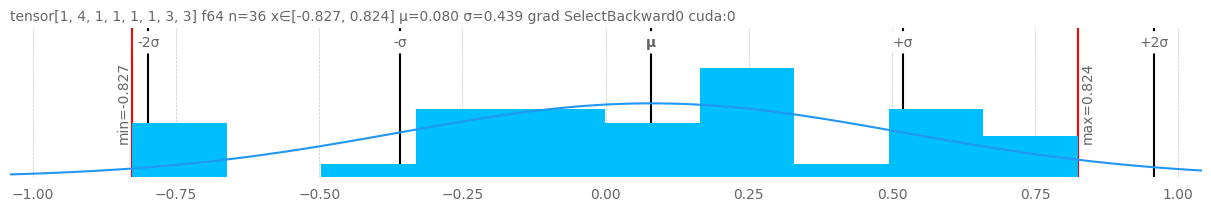

In [20]:
x0.real.plt()

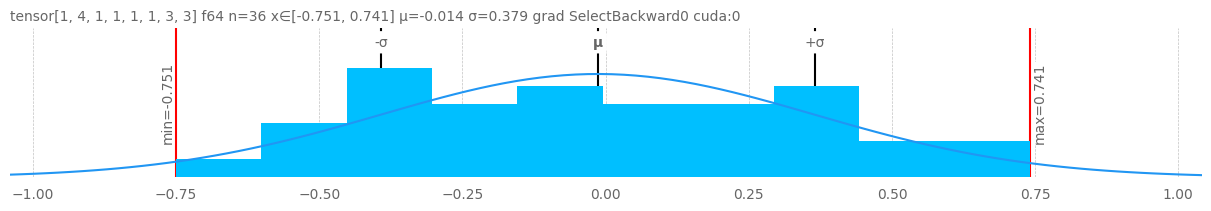

In [21]:
x0.imag.plt

### HMC

In [22]:
from l2hmc.experiment.pytorch.experiment import evaluate  # noqa

xhmc, history_hmc = evaluate(
    nsteps=100,
    exp=ptExpSU3,
    beta=6.0,
    x=x0,
    eps=0.1,
    nleapfrog=1,
    job_type='hmc',
    nlog=2,
    nprint=25,
    grab=True
)

[07/03/23 13:11:30][INFO][experiment.py:58] - Running 100 steps of hmc at beta=6.0000
[07/03/23 13:11:30][INFO][experiment.py:62] - STEP: 0
[07/03/23 13:11:30][INFO][experiment.py:62] - STEP: 1
[07/03/23 13:11:30][INFO][experiment.py:62] - STEP: 2
[07/03/23 13:11:30][INFO][experiment.py:62] - STEP: 3
[07/03/23 13:11:30][INFO][experiment.py:62] - STEP: 4
[07/03/23 13:11:31][INFO][experiment.py:62] - STEP: 5
[07/03/23 13:11:31][INFO][experiment.py:62] - STEP: 6
[07/03/23 13:11:31][INFO][experiment.py:62] - STEP: 7
[07/03/23 13:11:31][INFO][experiment.py:62] - STEP: 8
[07/03/23 13:11:31][INFO][experiment.py:62] - STEP: 9
[07/03/23 13:11:31][INFO][experiment.py:62] - STEP: 10
[07/03/23 13:11:31][INFO][experiment.py:62] - STEP: 11
[07/03/23 13:11:31][INFO][experiment.py:62] - STEP: 12
[07/03/23 13:11:31][INFO][experiment.py:62] - STEP: 13
[07/03/23 13:11:31][INFO][experiment.py:62] - STEP: 14
[07/03/23 13:11:31][INFO][experiment.py:62] - STEP: 15
[07/03/23 13:11:31][INFO][experiment.py:62] 

In [23]:
plt.rcParams['figure.figsize']

[12.4, 4.8]

In [24]:
plt.rcParams['figure.figsize'] = [12.4, 4.8]

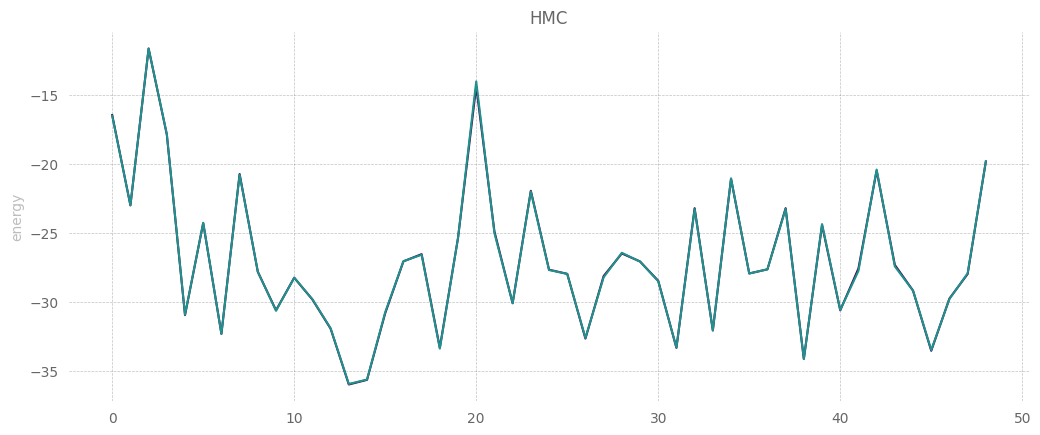

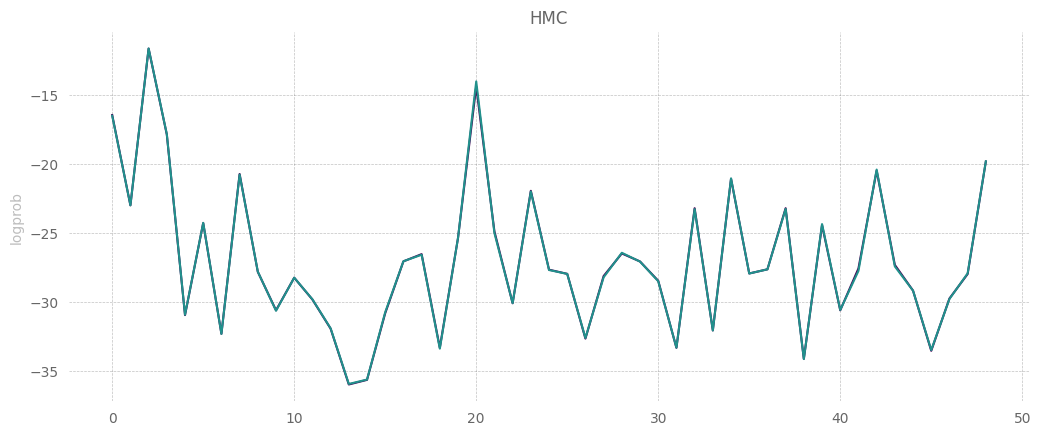

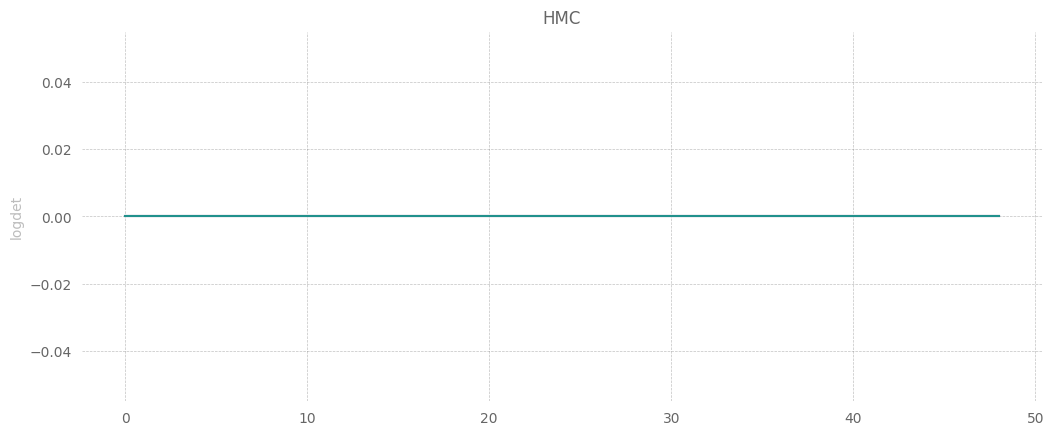

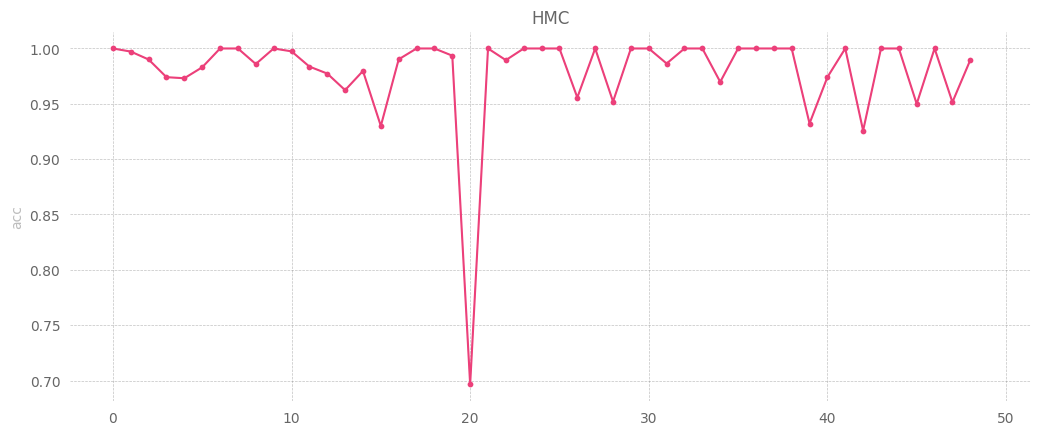

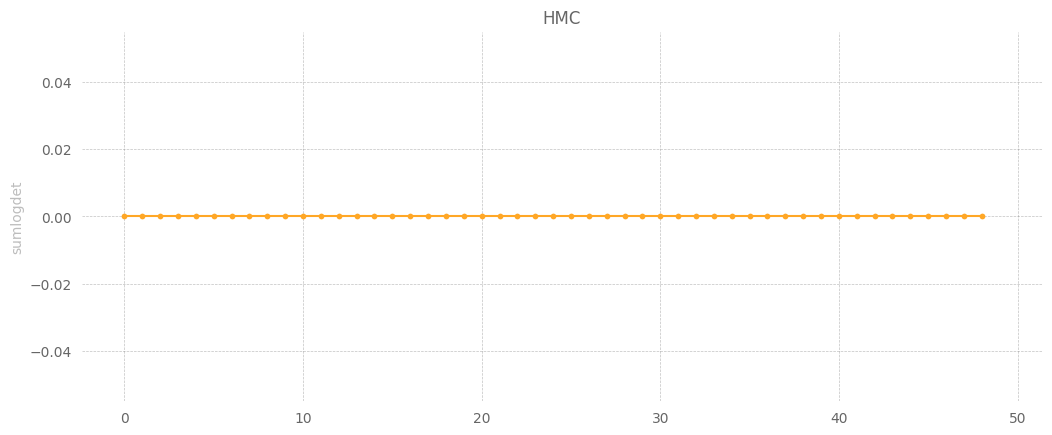

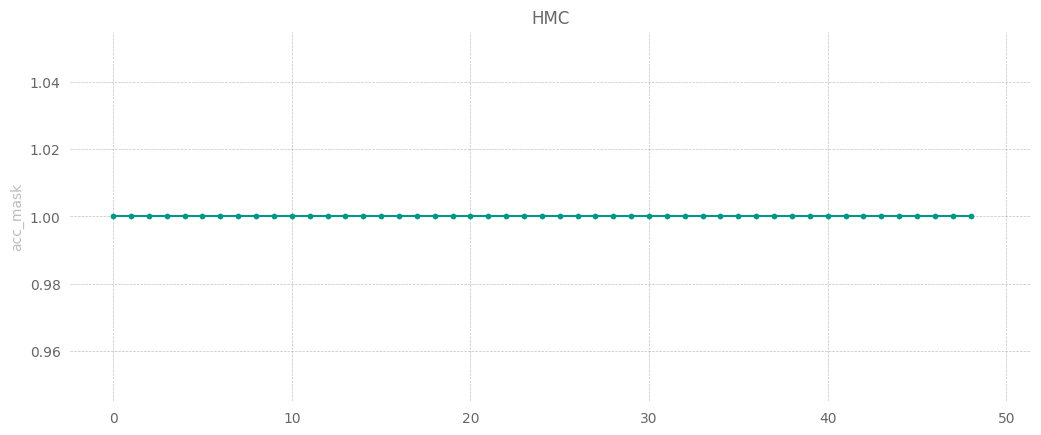

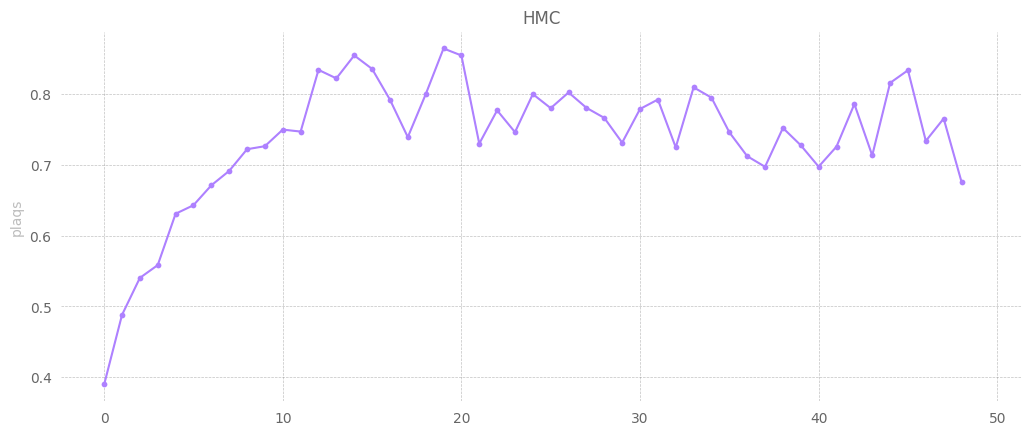

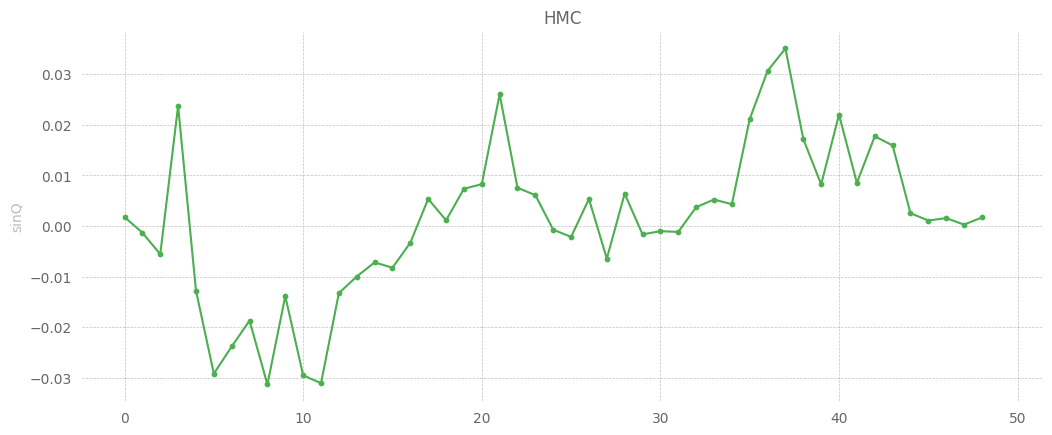

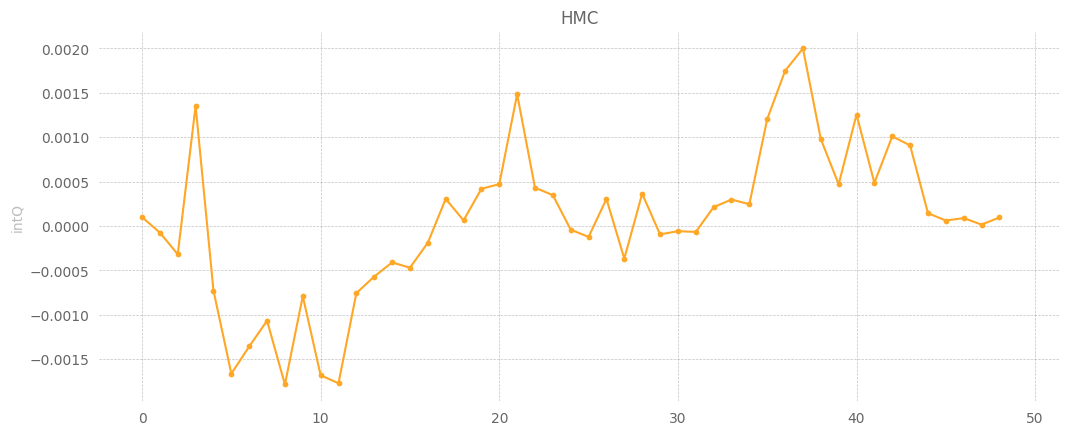

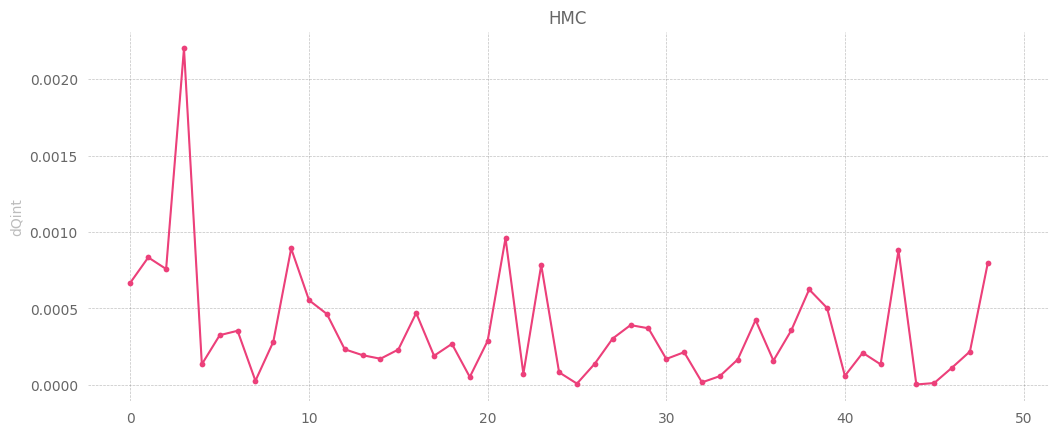

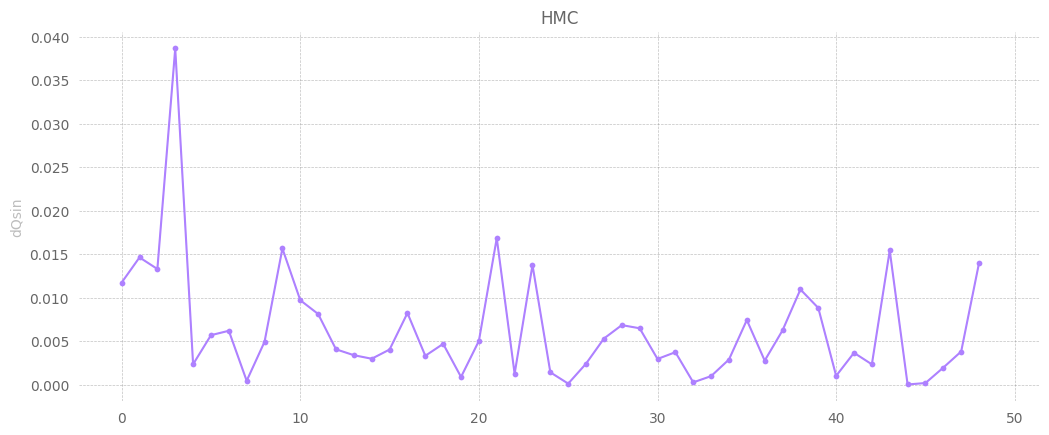

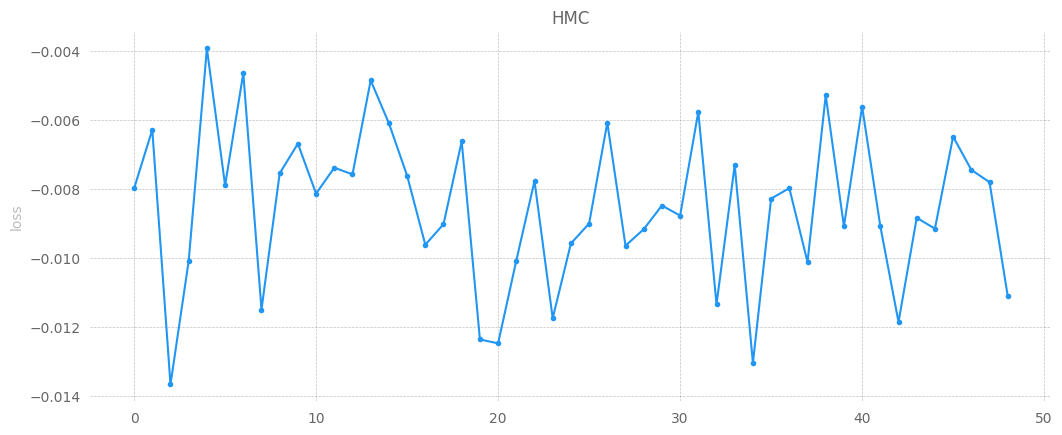

In [25]:
plot_metrics(history_hmc, title='HMC', marker='.')

### Inference

In [26]:
torch.set_printoptions(precision=8)

In [27]:
ptExpSU3.trainer.dynamics.init_weights(
    method='uniform',
    min=-1e-64,
    max=1e-64,
    bias=True,
)

#nlf = ptExpSU3.trainer.dynamics.config.nleapfrog
#eps = torch.tensor(0.10)

#ptExpSU3.trainer.dynamics.xeps = torch.stack(
#    [
#        eps for _ in range(nlf)
#    ]
#)
#ptExpSU3.trainer.dynamics.veps = torch.stack(
#    [
#        eps for _ in range(nlf)
#    ]
#)

In [28]:
np.set_printoptions(precision=5)
torch.set_printoptions(precision=5)

In [29]:
print_grads_and_weights(ptExpSU3.trainer)

--------------------------------------------------------------------------------

GRADS:

[07/03/23 13:11:40][INFO][common.py:97] - networks.xnet.input_layer.xlayer.weight: None
networks.xnet.input_layer.xlayer.bias: None
networks.xnet.input_layer.vlayer.weight: None
networks.xnet.input_layer.vlayer.bias: None
networks.xnet.scale.coeff: None
networks.xnet.scale.layer.weight: None
networks.xnet.scale.layer.bias: None
networks.xnet.transf.coeff: None
networks.xnet.transf.layer.weight: None
networks.xnet.transf.layer.bias: None
networks.xnet.transl.weight: None
networks.xnet.transl.bias: None
networks.vnet.input_layer.xlayer.weight: None
networks.vnet.input_layer.xlayer.bias: None
networks.vnet.input_layer.vlayer.weight: None
networks.vnet.input_layer.vlayer.bias: None
networks.vnet.scale.coeff: None
networks.vnet.scale.layer.weight: None
networks.vnet.scale.layer.bias: None
networks.vnet.transf.coeff: None
networks.vnet.transf.layer.weight: None
networks.vnet.transf.layer.bias: None
networks.vnet.transl.weight: None
networks.vnet.transl.bias: None
xeps.0: None
veps.0: None


--------------------------------------------------------------------------------

WEIGHTS:

[07/03/23 13:11:40][INFO][common.py:97] - networks.xnet.input_layer.xlayer.weight: Parameter containing:
Parameter[1, 72] f64 x∈[-9.722e-65, 9.726e-65] μ=-8.118e-66 σ=5.940e-65 grad cuda:0
networks.xnet.input_layer.xlayer.bias: Parameter containing:
Parameter[1] f64 grad cuda:0 [-8.628e-66]
networks.xnet.input_layer.vlayer.weight: Parameter containing:
Parameter[1, 72] f64 x∈[-9.932e-65, 9.745e-65] μ=-1.664e-66 σ=5.411e-65 grad cuda:0
networks.xnet.input_layer.vlayer.bias: Parameter containing:
Parameter[1] f64 grad cuda:0 [2.121e-65]
networks.xnet.scale.coeff: Parameter containing:
Parameter[1, 36] f64 all_zeros grad cuda:0
networks.xnet.scale.layer.weight: Parameter containing:
Parameter[36, 1] f64 x∈[-9.234e-65, 9.957e-65] μ=1.460e-65 σ=5.943e-65 grad cuda:0
networks.xnet.scale.layer.bias: Parameter containing:
Parameter[36] f64 x∈[-9.807e-65, 8.920e-65] μ=1.114e-65 σ=5.382e-65 grad cuda:0
networks.xnet.transf.coeff: Parameter containing:
Parameter[1, 36] f64 all_zeros grad cuda:0
n

--------------------------------------------------------------------------------

In [30]:
from l2hmc.experiment.pytorch.experiment import evaluate  # noqa

#ptExpSU3.trainer.dynamics.init_weights()
#    #constant=np.random.randn() / 1e10
#    constant=0.0,
#)

xeval, history_eval = evaluate(
    nsteps=100,
    exp=ptExpSU3,
    beta=6.0,
    x=x0,
    job_type='eval',
    nlog=2,
    nprint=25,
    grab=True,
)

[07/03/23 13:11:40][INFO][experiment.py:58] - Running 100 steps of eval at beta=6.0000
[07/03/23 13:11:40][INFO][experiment.py:62] - STEP: 0
[07/03/23 13:11:41][INFO][experiment.py:62] - STEP: 1
[07/03/23 13:11:41][INFO][experiment.py:62] - STEP: 2
[07/03/23 13:11:41][INFO][experiment.py:62] - STEP: 3
[07/03/23 13:11:41][INFO][experiment.py:62] - STEP: 4
[07/03/23 13:11:41][INFO][experiment.py:62] - STEP: 5
[07/03/23 13:11:41][INFO][experiment.py:62] - STEP: 6
[07/03/23 13:11:42][INFO][experiment.py:62] - STEP: 7
[07/03/23 13:11:42][INFO][experiment.py:62] - STEP: 8
[07/03/23 13:11:42][INFO][experiment.py:62] - STEP: 9
[07/03/23 13:11:42][INFO][experiment.py:62] - STEP: 10
[07/03/23 13:11:42][INFO][experiment.py:62] - STEP: 11
[07/03/23 13:11:42][INFO][experiment.py:62] - STEP: 12
[07/03/23 13:11:43][INFO][experiment.py:62] - STEP: 13
[07/03/23 13:11:43][INFO][experiment.py:62] - STEP: 14
[07/03/23 13:11:43][INFO][experiment.py:62] - STEP: 15
[07/03/23 13:11:43][INFO][experiment.py:62]

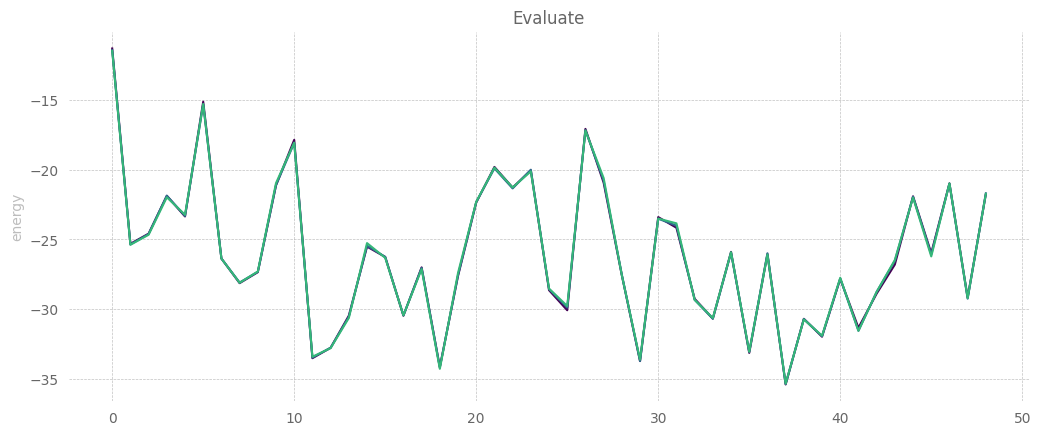

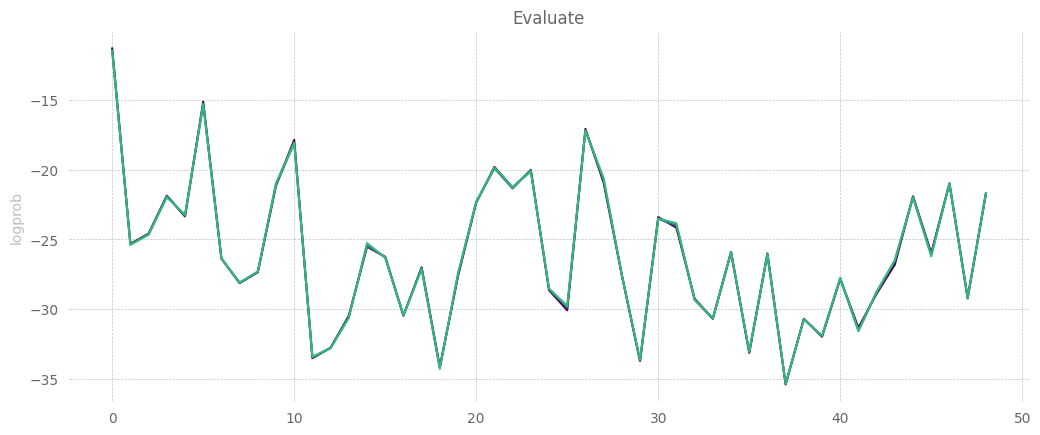

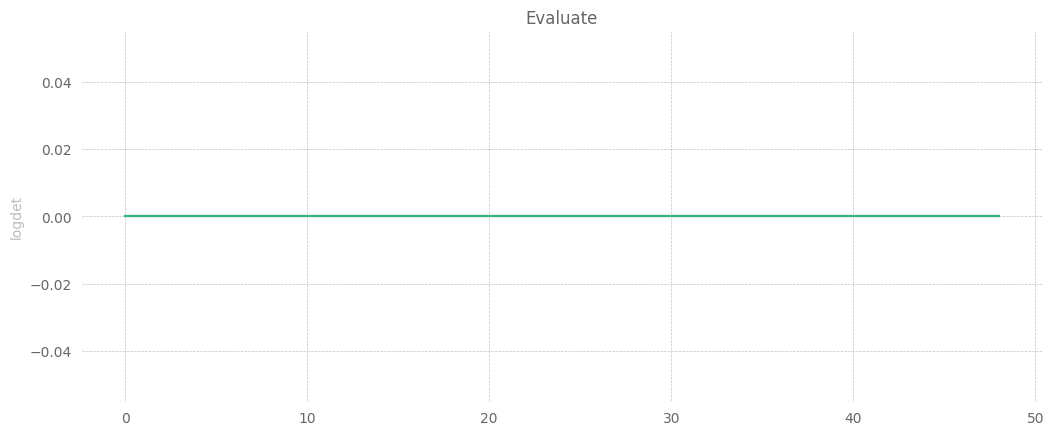

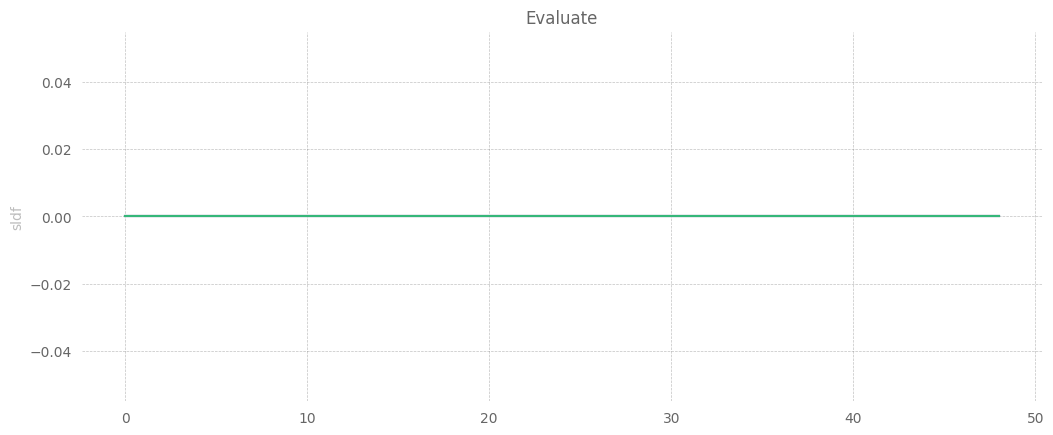

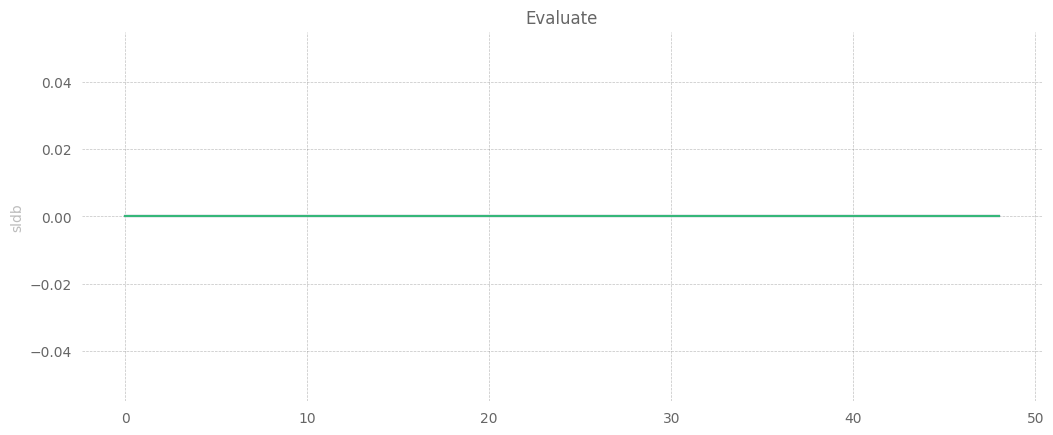

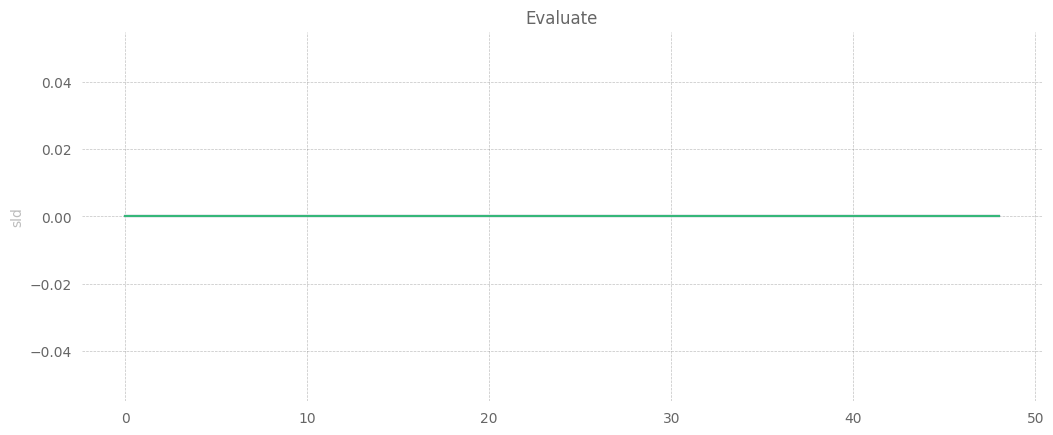

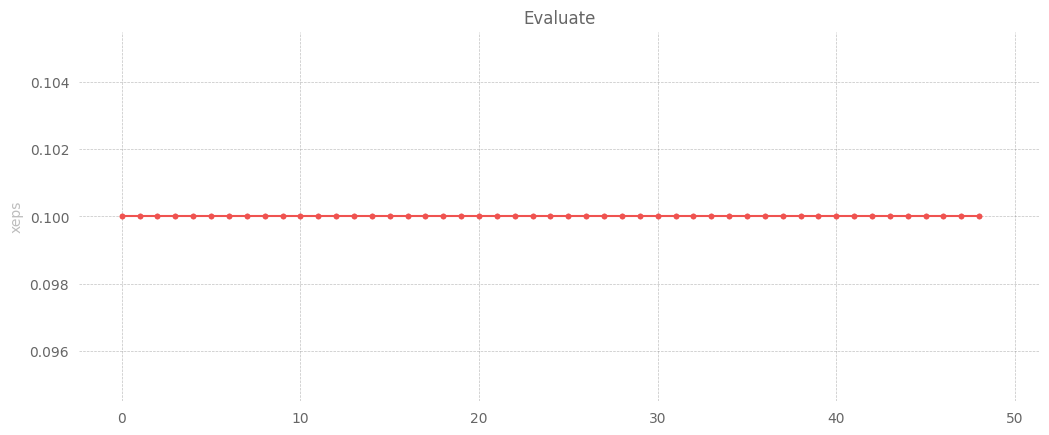

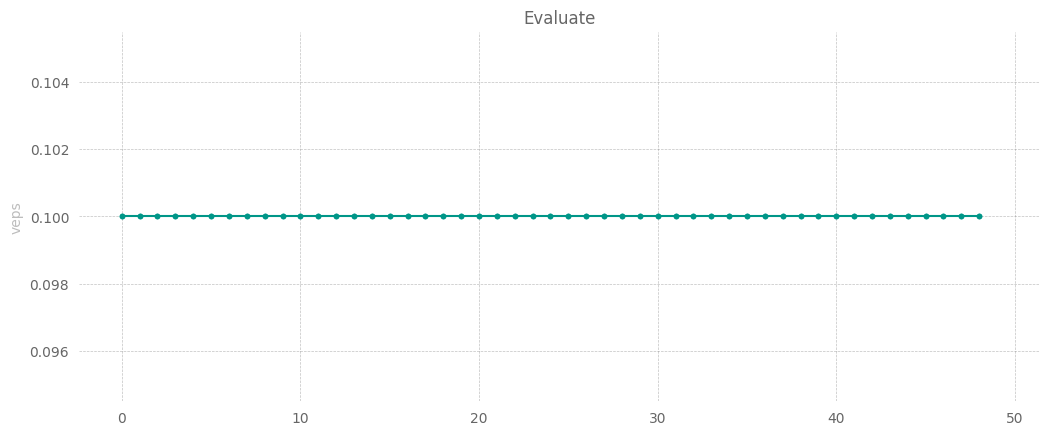

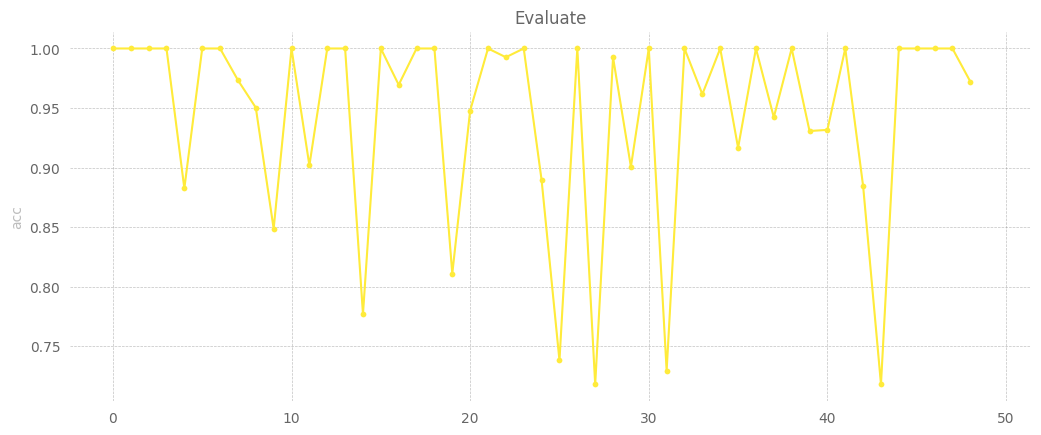

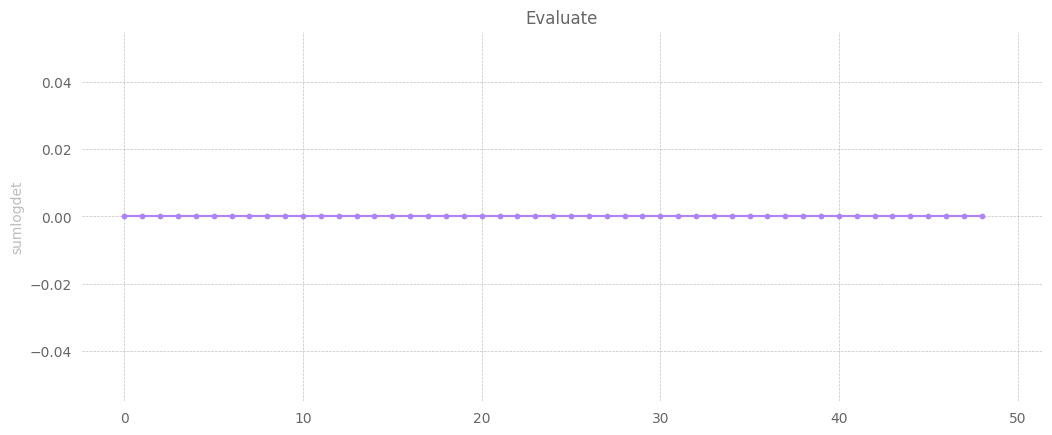

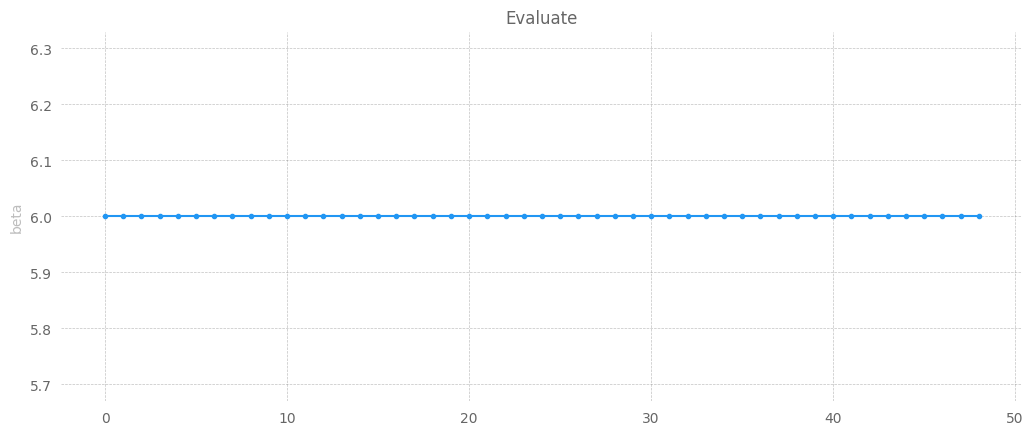

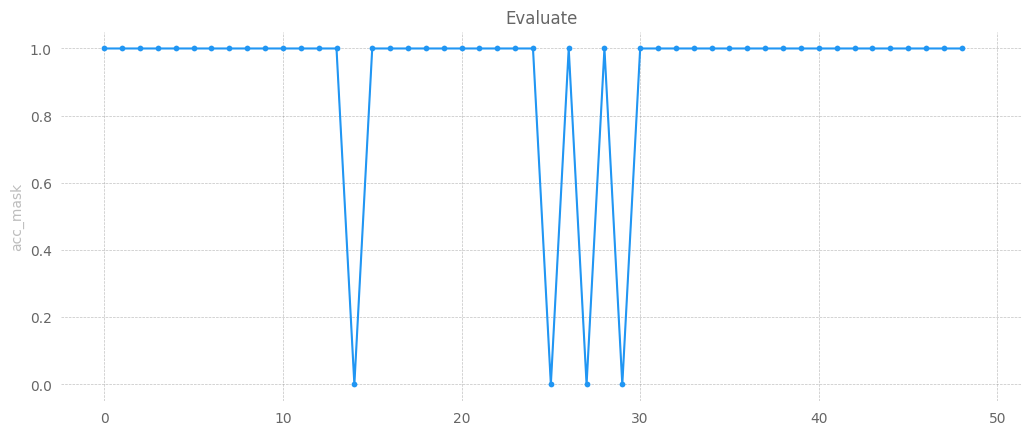

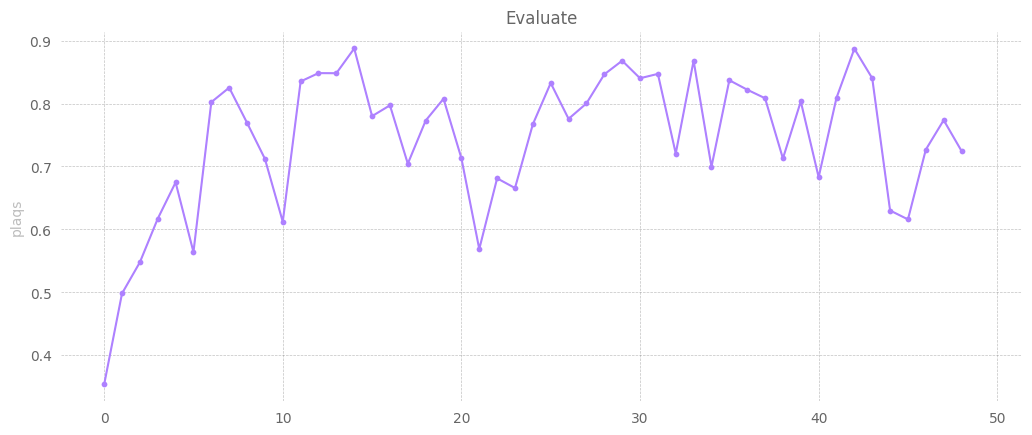

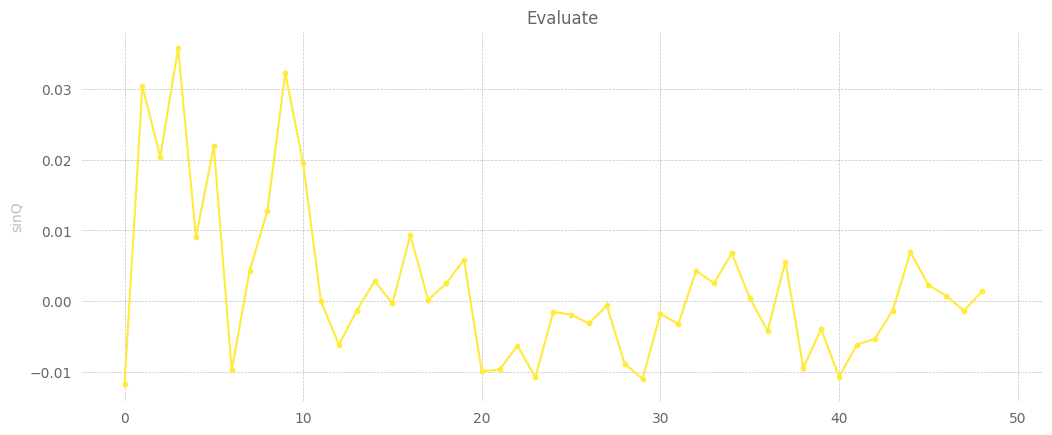

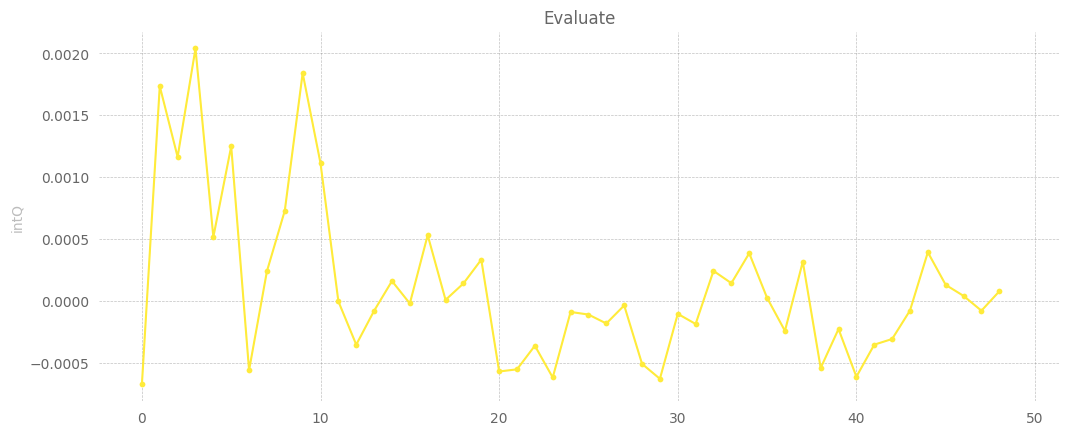

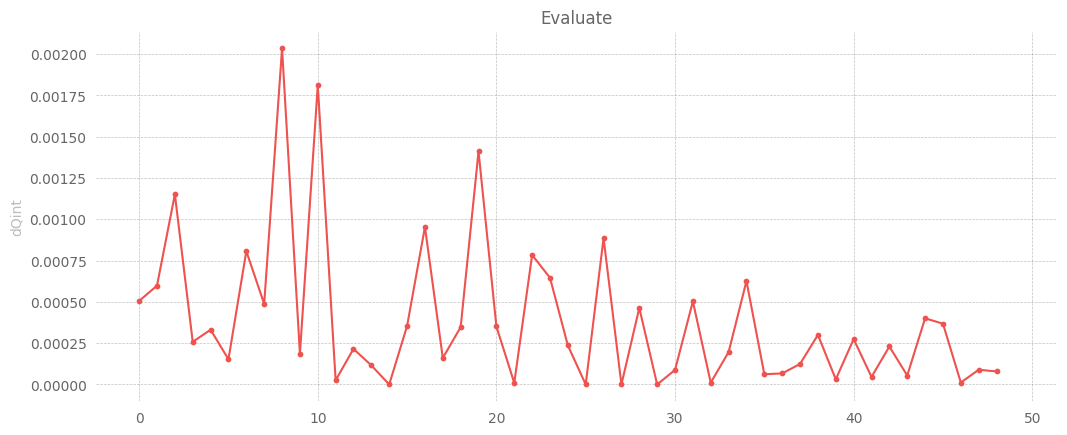

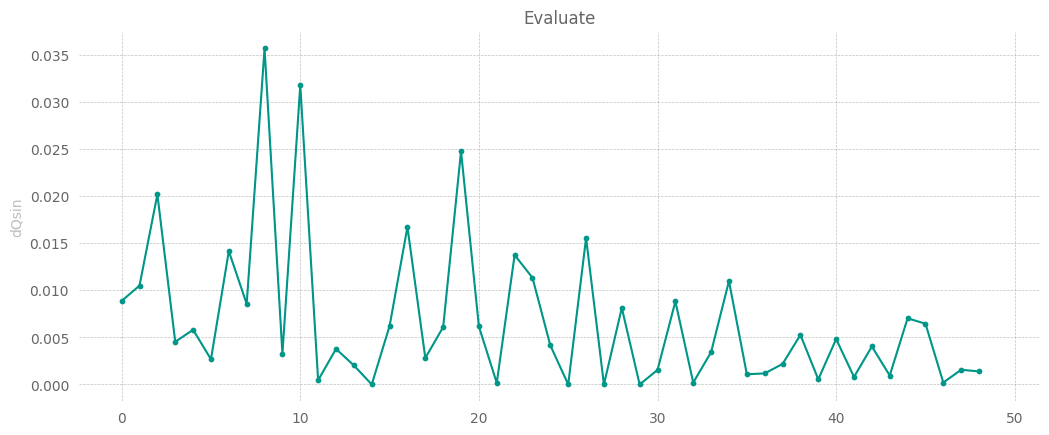

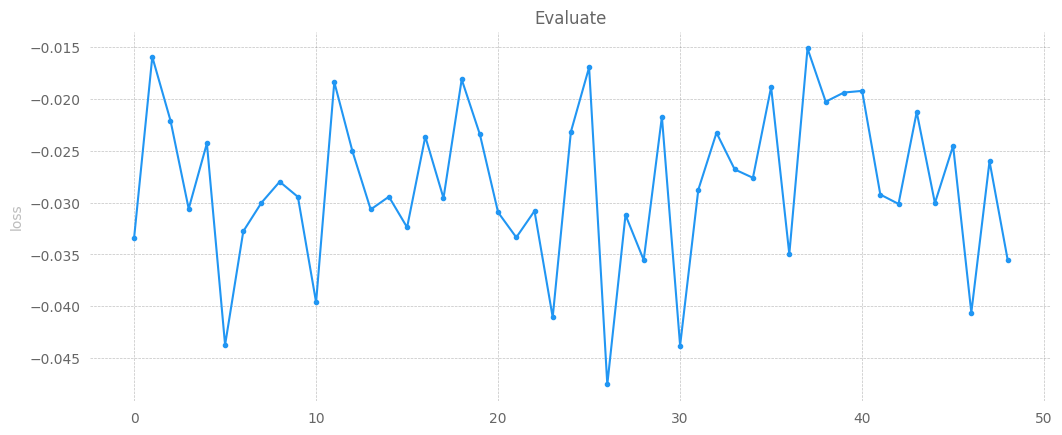

In [31]:
plot_metrics(history_eval, title='Evaluate', marker='.')

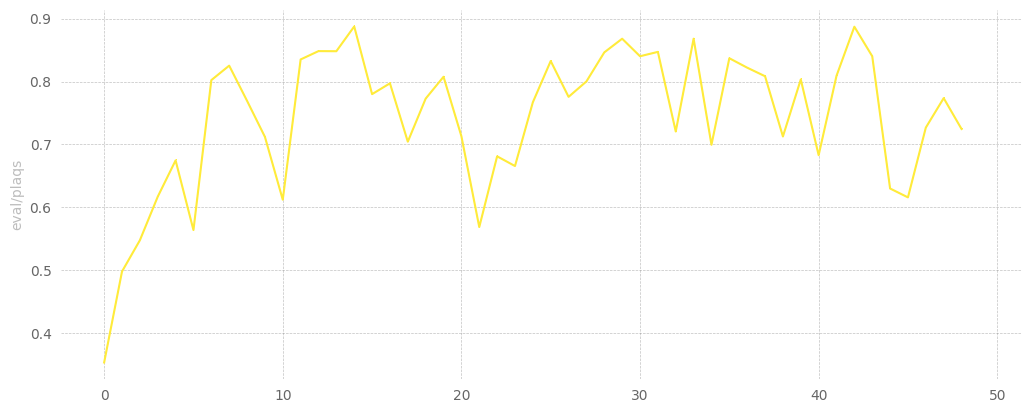

In [32]:
_ = plot_metric(history_eval['plaqs'], name='eval/plaqs', marker=',')

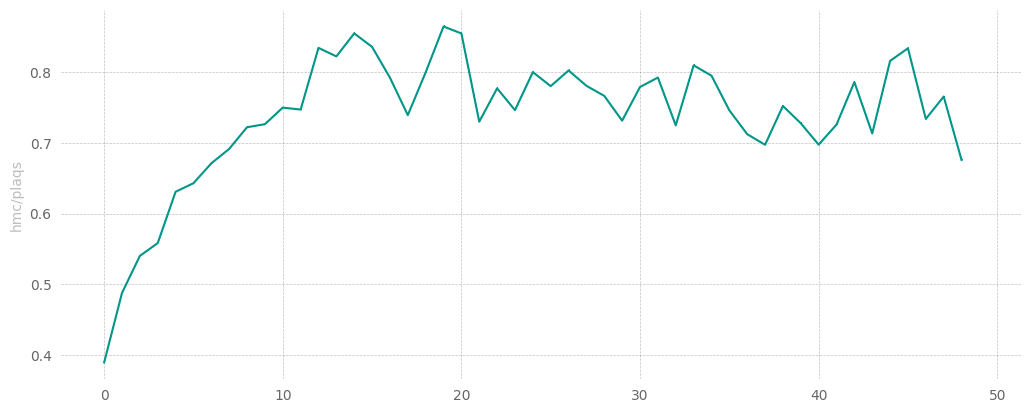

In [33]:
_ = plot_metric(history_hmc['plaqs'], name='hmc/plaqs', marker=',')

In [34]:
pratio = [
    ph / pe for (pe, ph) in zip(history_hmc['plaqs'], history_eval['plaqs'])
]
pdiff = [
    (ph - pe).abs() for (pe, ph) in zip(history_hmc['plaqs'], history_eval['plaqs'])
]

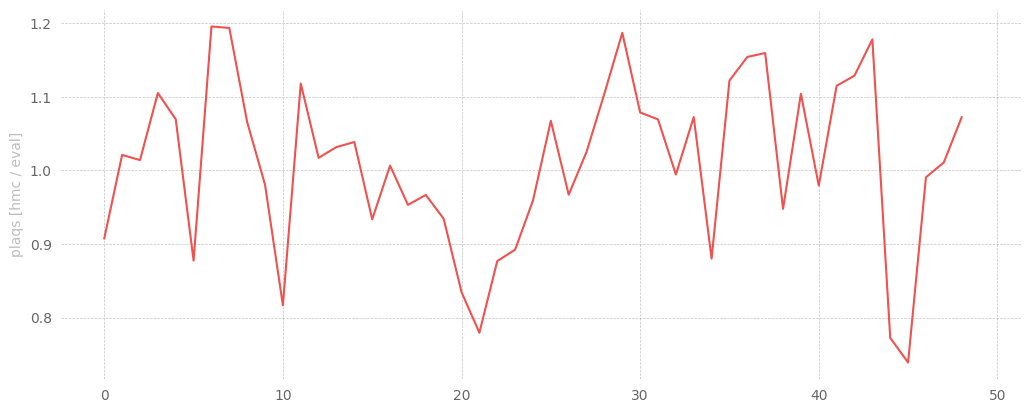

In [35]:
_ = plot_metric(pratio, name='plaqs [hmc / eval]')

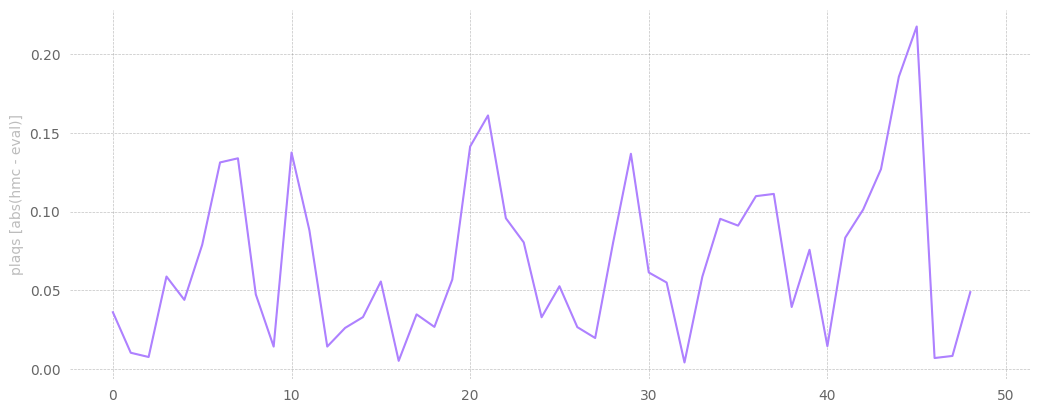

In [36]:
_ = plot_metric(pdiff, name='plaqs [abs(hmc - eval)]')

### Training

# Individual Training Step

Look at params / gradients both _before_ and _after_ a single training step

## Weights & Grads (before)

In [37]:
print(__file__)

/lus/grand/projects/datascience/foremans/locations/thetaGPU/projects/saforem2/l2hmc-qcd/src/l2hmc/notebooks/pytorch-4dSU3.ipynb

In [38]:
l2hmc.__file__

'/lus/grand/projects/datascience/foremans/locations/thetaGPU/projects/saforem2/l2hmc-qcd/src/l2hmc/__init__.py'

In [39]:
ptExpSU3.trainer.optimizer.zero_grad()
ptExpSU3.trainer.dynamics.init_weights(
    method='uniform',
    min=-1e-64,
    max=1e-64,
    bias=True,
    xeps=0.001,
    veps=0.001,
)
#nlf = ptExpSU3.trainer.dynamics.config.nleapfrog
#eps = torch.tensor(0.1, dtype=ptExpSU3.trainer.dynamics.xeps[0].dtype)
#ptExpSU3.trainer.dynamics.xeps = torch.stack(
#    [
#        eps for _ in range(nlf)
#    ]
#)
#ptExpSU3.trainer.dynamics.veps = torch.stack(
#    [
#        eps for _ in range(nlf)
#    ]
#)
#ptExpSU3.trainer.optimizer.zero_grad()
print_grads_and_weights(ptExpSU3.trainer)

--------------------------------------------------------------------------------

GRADS:

[07/03/23 13:14:16][INFO][common.py:97] - networks.xnet.input_layer.xlayer.weight: None
networks.xnet.input_layer.xlayer.bias: None
networks.xnet.input_layer.vlayer.weight: None
networks.xnet.input_layer.vlayer.bias: None
networks.xnet.scale.coeff: None
networks.xnet.scale.layer.weight: None
networks.xnet.scale.layer.bias: None
networks.xnet.transf.coeff: None
networks.xnet.transf.layer.weight: None
networks.xnet.transf.layer.bias: None
networks.xnet.transl.weight: None
networks.xnet.transl.bias: None
networks.vnet.input_layer.xlayer.weight: None
networks.vnet.input_layer.xlayer.bias: None
networks.vnet.input_layer.vlayer.weight: None
networks.vnet.input_layer.vlayer.bias: None
networks.vnet.scale.coeff: None
networks.vnet.scale.layer.weight: None
networks.vnet.scale.layer.bias: None
networks.vnet.transf.coeff: None
networks.vnet.transf.layer.weight: None
networks.vnet.transf.layer.bias: None
networks.vnet.transl.weight: None
networks.vnet.transl.bias: None
xeps.0: None
veps.0: None


--------------------------------------------------------------------------------

WEIGHTS:

[07/03/23 13:14:16][INFO][common.py:97] - networks.xnet.input_layer.xlayer.weight: Parameter containing:
Parameter[1, 72] f64 x∈[-9.573e-65, 9.303e-65] μ=1.778e-65 σ=5.816e-65 grad cuda:0
networks.xnet.input_layer.xlayer.bias: Parameter containing:
Parameter[1] f64 grad cuda:0 [1.553e-65]
networks.xnet.input_layer.vlayer.weight: Parameter containing:
Parameter[1, 72] f64 x∈[-9.959e-65, 9.608e-65] μ=-8.019e-67 σ=6.383e-65 grad cuda:0
networks.xnet.input_layer.vlayer.bias: Parameter containing:
Parameter[1] f64 grad cuda:0 [4.201e-66]
networks.xnet.scale.coeff: Parameter containing:
Parameter[1, 36] f64 all_zeros grad cuda:0
networks.xnet.scale.layer.weight: Parameter containing:
Parameter[36, 1] f64 x∈[-9.945e-65, 9.852e-65] μ=-1.031e-65 σ=6.136e-65 grad cuda:0
networks.xnet.scale.layer.bias: Parameter containing:
Parameter[36] f64 x∈[-8.953e-65, 9.975e-65] μ=2.042e-65 σ=5.652e-65 grad cuda:0
networks.xnet.transf.coeff: Parameter containing:
Parameter[1, 36] f64 all_zeros grad cuda:0
ne

--------------------------------------------------------------------------------

In [40]:
from rich import print
from torch import autograd

beta = torch.tensor(6.0)
zeros = torch.zeros_like(x0)
ones = torch.ones_like(x0)

dynamics = ptExpSU3.trainer.dynamics
config = ptExpSU3.config
g = ptExpSU3.trainer.g

x0_ = ptExpSU3.trainer.g.random(config.dynamics.xshape)
# NOTE: -----------------------------------------------
# >>> x0_.shape
# torch.Size([1, 4, 2, 2, 2, 2, 3, 3])
print(f'x0_.shape: {x0_.shape}')

avg, diff = g.checkSU(x0_)
print(f'avg: {avg}')
print(f'diff: {diff}')

x0_.shape: torch.Size([1, 4, 1, 1, 1, 1, 3, 3])

avg: tensor[1] f64 grad SqrtBackward0 cuda:0 [1.432e-15]

diff: tensor[1] f64 grad SqrtBackward0 cuda:0 [2.710e-15]

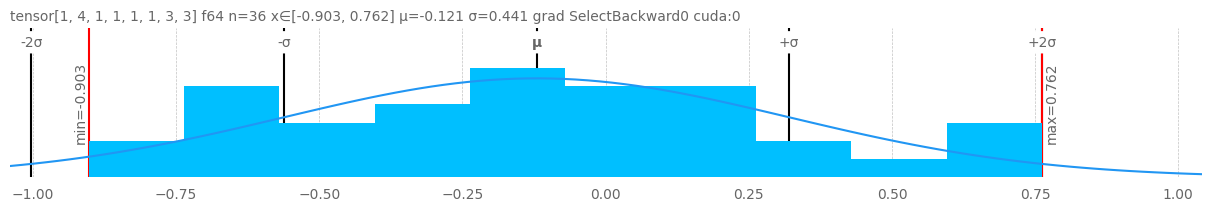

In [41]:
x0_.real.plt()

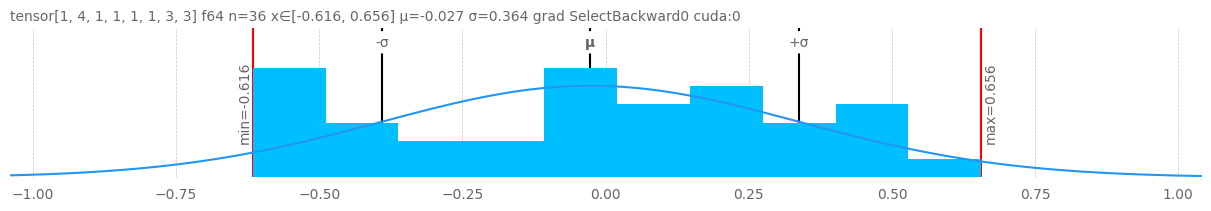

In [42]:
x0_.imag.plt()

In [54]:
trainer = ptExpSU3.trainer

with autograd.detect_anomaly(check_nan=True):
    x0_.requires_grad_(True)
    trainer.optimizer.zero_grad()
    xout, metrics = trainer.dynamics_engine((x0_, beta))
    xprop = metrics.pop('mc_states').proposed.x
    #_x0 = gpt.projectSU(x0_)
    #_xprop = gpt.projectSU(xprop)
    loss = calc_loss(x0_, xprop, metrics['acc'])
    loss.register_hook(lambda grad: grad.clamp_(max=1.0))
    print(loss)
    loss.backward()
    torch.nn.utils.clip_grad.clip_grad_norm(
        trainer.dynamics.parameters(),
        max_norm=0.1,
    )
    trainer.optimizer.step()
    metrics |= {'loss': loss.item()}
    print_dict(metrics, grab=False)
    #xout, metrics = train_step(x=x0_, beta=beta, trainer=ptExpSU3.trainer)
    #xout, metrics = ptExpSU3.trainer.train_step((x0_, beta))
    #loss = trainer.backward_step(loss)
    #dx = (x - xprop).abs().flatten(1).mean(-1)
    #loss = (metrics['acc'] * dx).mean()
    #loss = trainer.calc_loss(
    #    xinit=x,
    #    xprop=xprop,
    #    acc=metrics['acc']
    #)

tensor f64 grad SumBackward0 cuda:0 2.395e-06

[07/03/23 14:52:25][INFO][utils.py:302] - [hook] 1/d:
 tensor[1, 4, 1, 1, 1, 1] f64 all_zeros cuda:0 [[[[[[0.]]]], [[[[0.]]]], [[[[0.]]]], [[[[0.]]]]]]
[07/03/23 14:52:25][INFO][utils.py:302] - [hook] 1/d:
 tensor[1, 4, 1, 1, 1, 1] f64 all_zeros cuda:0 [[[[[[0.]]]], [[[[0.]]]], [[[[0.]]]], [[[[0.]]]]]]
[07/03/23 14:52:25][INFO][utils.py:302] - [hook] 1/d:
 tensor[1, 4, 1, 1, 1, 1] f64 all_zeros cuda:0 [[[[[[0.]]]], [[[[0.]]]], [[[[0.]]]], [[[[0.]]]]]]
[07/03/23 14:52:25][INFO][utils.py:302] - [hook] 1/d:
 tensor[1, 4, 1, 1, 1, 1] f64 all_zeros cuda:0 [[[[[[0.]]]], [[[[0.]]]], [[[[0.]]]], [[[[0.]]]]]]
[07/03/23 14:52:25][INFO][utils.py:302] - [hook] 1/d:
 tensor[1, 4, 1, 1, 1, 1] f64 all_zeros cuda:0 [[[[[[0.]]]], [[[[0.]]]], [[[[0.]]]], [[[[0.]]]]]]
[07/03/23 14:52:25][INFO][utils.py:302] - [hook] 1/d:
 tensor[1, 4, 1, 1, 1, 1] f64 all_zeros cuda:0 [[[[[[0.]]]], [[[[0.]]]], [[[[0.]]]], [[[[0.]]]]]]
[07/03/23 14:52:25][INFO][utils.py:302] - [hook] 1/d:
 tensor[1, 4, 1, 1, 1, 1] f64 all_

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ /tmp/ipykernel_3049446/2280193197.py:13 in <module>                                       │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_3049446/2280193197.py'               │
│                                                                                           │
│ /lus/grand/projects/datascience/foremans/locations/thetaGPU/miniconda3/envs/2023-04-26/li │
│ b/python3.10/site-packages/torch/_tensor.py:487 in backward                               │
│                                                                                           │
│    484 │   │   │   │   create_graph=create_graph,                                         │
│    485 │   │   │   │   inputs=inputs,                                                     │
│    486 │   │   │   )                                                                      │
│ ❱  487 │   │   torch.autograd.backward(                                                   │
│    488 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs              │
│    489 │   │   )                                                                          │
│    490                                                                                    │
│                                                                                           │
│ /lus/grand/projects/datascience/foremans/locations/thetaGPU/miniconda3/envs/2023-04-26/li │
│ b/python3.10/site-packages/torch/autograd/__init__.py:200 in backward                     │
│                                                                                           │
│   197 │   # The reason we repeat same the comment below is that                           │
│   198 │   # some Python versions print out the first line of a multi-line function        │
│   199 │   # calls in the traceback and some print out the last line                       │
│ ❱ 200 │   Variable._execution_engine.run_backward(  # Calls into the C++ engine to run th │
│   201 │   │   tensors, grad_tensors_, retain_graph, create_graph, inputs,                 │
│   202 │   │   allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine  │
│   203                                                                                     │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: Function 'ReciprocalBackward0' returned nan values in its 0th output.

In [ ]:
x = ptExpSU3.trainer.g.random(config.dynamics.xshape)
xout, metrics = train_step(x=x, beta=beta, trainer=ptExpSU3.trainer)

In [ ]:
with autograd.detect_anomaly(check_nan=True):
    #xout, metrics = train_step(x=x0_, beta=beta, trainer=ptExpSU3.trainer)
    xout, metrics = ptExpSU3.trainer.train_step((x0_, beta))

In [ ]:
%debug

In [ ]:
import l2hmc.group.su3.pytorch.utils as gputils

x = x0_
tr = torch.diagonal(x, dim1=-2, dim2=-1).sum(-1).real
x2 = torch.matmul(x, x)
p2 = torch.diagonal(x2, dim1=-2, dim2=-1).sum(-1).real
det = x.det().real
e0, e1, e2 = gputils.eigs3x3(tr, p2, det)
se0 = e0.abs().sqrt()
se1 = e1.abs().sqrt()
se2 = e2.abs().sqrt()
u = se0 + se1 + se2
w = se0 * se1 * se2
d = w * (se0 + se1) * (se0 + se2) * (se1 + se2)
di = 1.0 / d
c0_ = di * (
    w * u * u
    + e0 * se0 * (e1 + e2)
    + e1 * se1 * (e0 + e2)
    + e2 * se2 * (e0 + e1)
)
c1_ = -(tr * u + w) * di
c2_ = u * di

#c0_, c1_, c2_ = gputils.rsqrtPHM3f(tr, p2, det)
c0 = c0_.reshape(c0_.shape + (1, 1)).type_as(x)
c1 = c1_.reshape(c1_.shape + (1, 1)).type_as(x)
c2 = c2_.reshape(c2_.shape + (1, 1)).type_as(x)

rsq = c0 * gputils.eyeOf(x) + c1 * x + c2 * x2

In [ ]:
e1.shape

In [ ]:
rsq.shape

In [ ]:
e1

In [ ]:
e0_, e1_, e2_ = gputils.su3_to_eigs(x).T

In [ ]:
e0_.shape

In [ ]:
e0_.real.plt()

In [ ]:
e0.real.plt()

In [ ]:
e1.real.plt()

In [ ]:
e1_.real.plt()

In [ ]:
p3x3 = gputils.charpoly3x3(x)
zs = gputils.cubic_zeros(p3x3)

In [ ]:
eigs_.shape

In [ ]:
len(p3x3)

In [ ]:
eig0, eig1, eig2 = p3x3

In [ ]:
eig0

In [ ]:
eig0.shape

In [ ]:
eigs_.shape

In [ ]:
c0.shape

In [ ]:
c0, c1, c2

In [ ]:
c0.real.plt()

In [ ]:
c1.real.plt()

In [ ]:
c2.real.plt()

In [ ]:
rsq.shape

In [ ]:
rsq.real.plt()

In [ ]:
rsq.imag.plt()

In [ ]:
with autograd.detect_anomaly(check_nan=True):
    #xout, metrics = ptExpSU3.trainer.train_step((x0_, beta))
    xout, metrics = ptExpSU3.trainer.dynamics((x0_, beta))
    xprop = metrics.pop('mc_states').proposed.x
    acc = metrics['acc']
    dx = (xprop - x0_)
    dx2 = (dx.real ** 2 + dx.imag ** 2).flatten(1)
    loss = (acc * dx2.sum(-1)).mean()
    loss = ptExpSU3.trainer.backward_step(loss)

In [ ]:
xout, metrics = ptExpSU3.trainer.dynamics((x0_, beta))
xprop = metrics.pop('mc_states').proposed.x
acc = metrics['acc']
dx = (xprop - x0_)
dx2 = (dx.real ** 2 + dx.imag ** 2).flatten(1)
loss = (acc * dx2.sum(-1)).mean()
loss

In [ ]:
metrics.keys()

In [ ]:
acc = metrics['acc']
dx = (xprop - x0_)
dx2 = (dx.real ** 2 + dx.imag ** 2).flatten(1)
dx
dx2.shape

In [ ]:
acc.shape

In [ ]:
with autograd.detect_anomaly(check_nan=True):
    xout, metrics = ptExpSU3.trainer.train_step((x0_, beta))

In [ ]:
with autograd.detect_anomaly(check_nan=True):
    xout, metrics = train_step(x=x0_, beta=beta, trainer=ptExpSU3.trainer)

In [ ]:
config.dynamics.xshape

In [ ]:
x0_.shape

In [ ]:
avg, diff = g.checkSU(x0_)

In [ ]:
avg

In [ ]:
diff

In [ ]:
p0_ = dynamics.group_to_vec(ptExpSU3.trainer.g.random_momentum(config.dynamics.xshape)a)

In [ ]:
p0_.shape

In [ ]:
with autograd.detect_anomaly(check_nan=True):
    xout, metrics = train_step(x=zeros, beta=beta, trainer=ptExpSU3.trainer)

In [ ]:
%debug

In [ ]:
import l2hmc.group.su3.pytorch.utils as gutils

x = x0

tr = torch.diagonal(x, dim1=-2, dim2=-1).sum(-1).real
x2 = x @ x
p2 = torch.diagonal(x2, dim1=-2, dim2=-1).sum(-1).real
det = x.det().real
c0_, c1_, c2_ = gutils.rsqrtPHM3f(tr=tr, p2=p2, det=det)

c0 = c0_.reshape(c0_.shape + (1, 1)).to(x.dtype)
c1 = c1_.reshape(c1_.shape + (1, 1)).to(x.dtype)
c2 = c2_.reshape(c2_.shape + (1, 1)).to(x.dtype)

In [ ]:
e0, e1, e2 = gutils.eigs3x3(tr=tr, p2=p2, det=det)

In [ ]:
e0

In [ ]:
e1

In [ ]:
e2

In [ ]:
eigs = gutils.su3_to_eigs(x)

In [ ]:
eigs.shape

In [ ]:
eigs[:, 0].real.plt

In [ ]:
eigs[:, 0].imag.plt

In [ ]:
c0.real.plt

In [ ]:
c0.imag.plt()

In [ ]:
c1.real.plt

In [ ]:
c1.imag.plt

In [ ]:
c2.real.plt

In [ ]:
c2.imag.plt

In [ ]:
print_grads_and_weights(trainer=ptExpSU3.trainer, grab=True)

## Weights & Grads (after)

<div class="alert alert-block alert-danger">
🤷🏻‍♂️ <b>nothing but <code>NaN</code>s</b>
</div>

### Traceback

```python
>>> with autograd.detect_anomaly(check_nan=True):
        xout, metrics = train_step(x=zeros, beta=beta, trainer=ptExpSU3.trainer)
╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ /tmp/ipykernel_3122378/423843456.py:2 in <module>                                         │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_3122378/423843456.py'                │
│                                                                                           │
│ /tmp/ipykernel_3122378/2245892909.py:65 in train_step                                     │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_3122378/2245892909.py'               │
│                                                                                           │
│ /lus/grand/projects/datascience/foremans/locations/thetaGPU/miniconda3/envs/2023-04-26/li │
│ b/python3.10/site-packages/torch/_tensor.py:487 in backward                               │
│                                                                                           │
│    484 │   │   │   │   create_graph=create_graph,                                         │
│    485 │   │   │   │   inputs=inputs,                                                     │
│    486 │   │   │   )                                                                      │
│ ❱  487 │   │   torch.autograd.backward(                                                   │
│    488 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs              │
│    489 │   │   )                                                                          │
│    490                                                                                    │
│                                                                                           │
│ /lus/grand/projects/datascience/foremans/locations/thetaGPU/miniconda3/envs/2023-04-26/li │
│ b/python3.10/site-packages/torch/autograd/__init__.py:200 in backward                     │
│                                                                                           │
│   197 │   # The reason we repeat same the comment below is that                           │
│   198 │   # some Python versions print out the first line of a multi-line function        │
│   199 │   # calls in the traceback and some print out the last line                       │
│ ❱ 200 │   Variable._execution_engine.run_backward(  # Calls into the C++ engine to run th │
│   201 │   │   tensors, grad_tensors_, retain_graph, create_graph, inputs,                 │
│   202 │   │   allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine  │
│   203                                                                                     │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: Function 'AcosBackward0' returned nan values in its 0th output.
```


In [ ]:
print_grads_and_weights(ptExpSU3.trainer)

Try to re-init weights

In [ ]:
ptExpSU3.trainer.optimizer.zero_grad()

In [ ]:
ptExpSU3.trainer.dynamics.init_weights(
    method='uniform',
    min=-1e-36,
    max=1e-36,
    bias=True,
)
#nlf = ptExpSU3.trainer.dynamics.config.nleapfrog
#eps = torch.tensor(0.1, dtype=ptExpSU3.trainer.dynamics.xeps[0].dtype)
#ptExpSU3.trainer.dynamics.xeps = torch.stack(
#    [
#        eps for _ in range(nlf)
#    ]
#)
#ptExpSU3.trainer.dynamics.veps = torch.stack(
#    [
#        eps for _ in range(nlf)
#    ]
#)
#ptExpSU3.trainer.optimizer.zero_grad()
print_grads_and_weights(ptExpSU3.trainer)

In [ ]:
from torch import autograd

#with autograd.detect_anomaly(check_nan=True):
#    xout, metrics = train_step(x=x0, beta=beta, trainer=ptExpSU3.trainer)


state = ptExpSU3.trainer.dynamics.random_state(beta=6.0)
x = state.x
beta = state.beta
ptExpSU3.trainer.optimizer.zero_grad(set_to_none=False)

with autograd.detect_anomaly(check_nan=True):
    xout, metrics = ptExpSU3.trainer.dynamics((x, beta))
    xprop = metrics.pop('mc_states').proposed.x
    loss = calc_loss(x, xprop, metrics['acc'])
    #import pdb ; pdb.set_trace()
    loss.backward()
    torch.nn.utils.clip_grad.clip_grad_norm(
        trainer.dynamics.parameters(),
        max_norm=float(1e-16),
    )
    ptExpSU3.trainer.optimizer.step()
    metrics |= {'loss': loss.item()}
    print_dict(metrics, grab=False)